# Making the decline detection better

Building on top of our findings in milestone 2, we find a technique to better detect declines.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import tqdm
import copy
import csv

from src.data.dataloader_functions import *
from src.data.final_dataset_creation import *
from src.utils.results_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Load the data:

Re-compute the rolling growth rate and store it to file

/!\ Note: Running the following cell is very time-consuming and requires around 16GB of memory. Run it only if you don't have the file `df_with_rgr.csv` in the `data` folder.

In [ ]:
# Load the original data for the index
original_data = load_processed_data(verbose = True)

ROLLING_WINDOW = 20  # Set the rolling window for the growth rate, (5 months by default, could be changed in the future)

# Initialize an empty DataFrame to store the results
result = pd.DataFrame()

# Iterate over each group with a progress bar
for name, group in tqdm(original_data.groupby('channel'), desc="Processing channels"):
    group['rolling_growth_rate'] = group['delta_subs'].rolling(ROLLING_WINDOW, min_periods=ROLLING_WINDOW).mean()
    result = pd.concat([result, group])

result['growth_diff'] = result['delta_subs'] - result['rolling_growth_rate']

result.to_csv('data/df_with_rgr_new.tsv', sep='\t', index=True)

We now create the final dataset that we will use through this study, with a new technique:

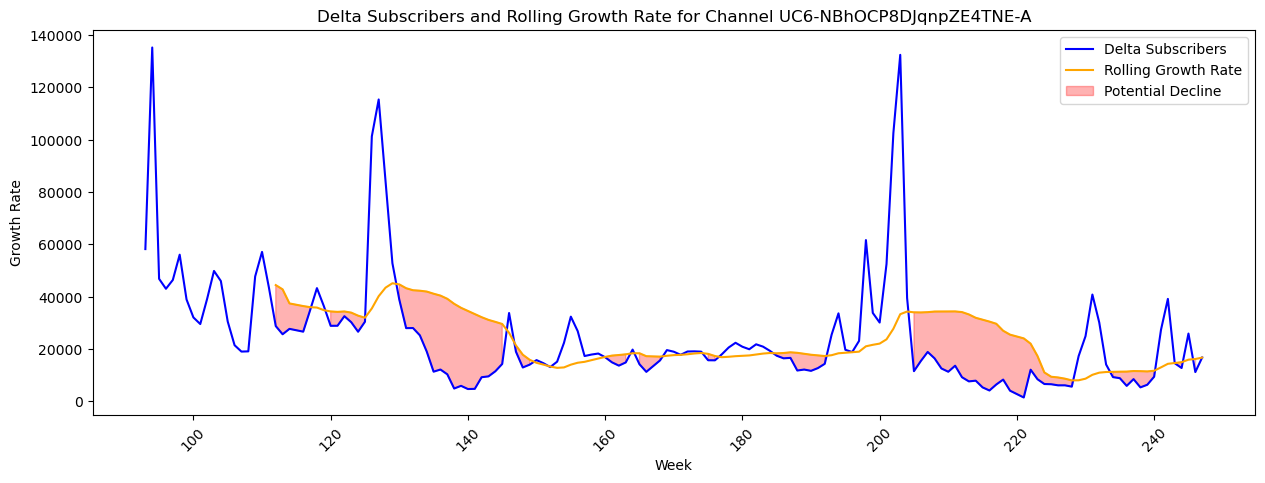

Now, we obtain less decline events,  but more meaningful ones.


In [2]:
create_datasets(verbose=False)